In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import xml.etree.ElementTree as ET
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression



In [5]:
xml_file = 'drive/MyDrive/semcor+omsti.data.xml'
gold_key = 'drive/MyDrive/semcor+omsti.gold.key.txt'
test_xml_file = 'drive/MyDrive/ALL.data.xml'
test_gold_key = 'drive/MyDrive/ALL.gold.key.txt'

In [ ]:

def find_corpus(file_name):
    with open(file_name, 'r') as file:
        lines = file.read()
        a = (len(lines)//1)
        # print(a)
        # print(lines.count("/corpus"))
        i = 0
        while "<corpus" in lines:
          i +=1
          index = lines.index("<corpus")
          # print(lines[index:index+a//100])
          index2 = lines.index("</corpus")



          # print(index,index2)
          corpus = lines[index:index2]
        #   print(index,index2,lines[index2-10:index2+10])
          lines = lines[0:index] + lines[index2+10:]
          with open(f'drive/MyDrive/temp{i}.xml', 'w') as file:

              file.write('<?xml version="1.0" encoding="UTF-8" ?>\n')
              file.write('<root>\n')
              file.write(corpus)
              file.write('</corpus>\n')
              file.write('</root>\n')


find_corpus(xml_file)


In [7]:
def divide_corpus(file_name):
    with open(file_name, 'r') as file:
        lines = file.read()
        a = (len(lines)//10)
        # print(lines.count("/sentence"))
        i = 0
        while "<sentence" in lines:
          i +=1
          index = lines.index("<sentence")
          # print(lines[index:index+a//100])
          index2 = a + lines[a:].index("</sentence")
          if len(lines) < 2* a:
              index2 = lines.rindex("</sentence")



          # print(index,index2)
          corpus = lines[index:index2]
          # print(index,index2,lines[index2-10:index2+12])
          lines = lines[0:index] + lines[index2+12:]
          with open(f'drive/MyDrive/tempdd{i}.xml', 'w') as file:

              file.write('<?xml version="1.0" encoding="UTF-8" ?>\n')
              file.write('<root>\n')
              file.write(corpus)
              file.write('</sentence>\n')
              file.write('</root>\n')


divide_corpus("drive/MyDrive/temp2.xml")


In [8]:
dataset= {}
ins = 0

In [9]:

def process(file):
    # root = ET.fromstring(corpus)
    n = 0
    global ins
    tree = ET.parse(file)
    root = tree.getroot()
    # print(type(root))
    for sentence in root.findall('.//sentence'):
        # print(f"Sentence ID: {sentence.attrib['id']}")
        sent = ""
        pos_sent = ""
        n+=1
        for element in sentence:
            sent = sent + " " + element.text
            le = len(element.text.split())
            s = ''.join([element.attrib.get('pos') + " " for i in range(le)])
            pos_sent = pos_sent + s
        for element in sentence:
            if element.tag in ['instance']:
                  ins += 1
                  lemma = element.attrib.get('lemma')
                  id = element.attrib.get('id')
                  pos = element.attrib.get('pos')
                  if lemma not in dataset:
                    dataset[lemma] = []
                  # if element.text not in sent.split()
                  posit = sent.split().index(element.text.split()[0])
                  # doc = nlp(sent)

                  # sentence_vector = nlp(sent)
                  bow = sent.split()[max(posit-3,0):min(posit+3,(len(sent.split())))]
                  pos_before = 0
                  if posit > 0:
                    pos_before  = pos_sent.split()[posit-1]
                  pos_after = 0
                  if posit+1 <  len(pos_sent.split()):
                    pos_after  = pos_sent.split()[posit+1]
                  dataset[lemma].append([id,lemma, sent,pos,pos_sent,bow,element.text,pos_before,pos_after])

        # print(sent)

    # print(len(dataset))
    return n


In [10]:
#Processing the whole file can overloasd the RAM to avoid it the data is process in chunks
process("drive/MyDrive/temp1.xml")
for i in range(1,10):
    a=process(f'drive/MyDrive/tempdd{i}.xml')
    # print(a)
# print(ins)

In [11]:
import json
with open('drive/MyDrive/semcor+omstidataset.json', 'w') as file:
    json.dump(dataset, file, indent=2)

In [36]:
with open('drive/MyDrive/semcor+omstidataset.json', 'r') as file:
    dataset = json.load(file)

# print(d, dataset[d])

In [37]:
lines = []
with open(gold_key, 'r') as file:
    lines = file.readlines()

Y_values = {}
processed_data = []
for line in lines:
    words = line.strip().split()
    processed_data.append(words[1])
    Y_values[words[0]] = words[1]
#     print(item)

# print(len(processed_data))
# print(len(set(processed_data)))
# print(Y_values)

In [38]:

for lemma in dataset:
  for j in dataset[lemma]:
    y = Y_values[j[0]]
    pos = y.index('%')
    j.append(y[pos:pos+8])


In [ ]:
file_path = test_gold_key
with open(test_gold_key, 'r') as file:
    lines = file.readlines()

test_Y_values = {}
test_processed_data = []
for line in lines:
    words = line.strip().split()
    pos = line.index(" ")
    line = line[pos:]
    # test_processed_data.append(line)
    test_Y_values[words[0]] = line
#     print(item)
test_Y = test_processed_data

# print(len(test_processed_data))
# print(len(set(test_processed_data)))
# print(Y_values)

In [40]:

test_tree = ET.parse(test_xml_file)
test_root = test_tree.getroot()
# print(type(root))
test_dataset = {}
for sentence in test_root.findall('.//sentence'):
    # print(f"Sentence ID: {sentence.attrib['id']}")
    sent = ""
    pos_sent = ""
    for element in sentence:

            sent = sent + " " + element.text
            le = len(element.text.split())
            s = ''.join([element.attrib.get('pos') + " " for i in range(le)])
            pos_sent = pos_sent + s
    posit = 0
    for element in sentence:
        if element.tag in ['instance']:
              ins += 1
              lemma = element.attrib.get('lemma')
              id = element.attrib.get('id')
              pos = element.attrib.get('pos')
              if lemma not in test_dataset:
                test_dataset[lemma] = []
              posit = sent.split().index(element.text.split()[0])

              # doc = nlp(sent)
              # sentence_vector = doc.vector
              bow = sent.split()[max(posit-3,0):min(posit+3,(len(sent.split())))]

              pos_before = ""
              if posit > 0:
                if posit >= len(pos_sent.split()):
                  print("\n",posit)
                  print(len(pos_sent.split()))
                  print(len(sent.split()))
                  print(sent)
                  print(pos_sent)
                pos_before  = pos_sent.split()[posit-1]
              pos_after = ""
              if posit+1 <  len(pos_sent.split()):
                pos_after  = pos_sent.split()[posit+1]
              test_dataset[lemma].append([id,lemma, sent,pos,pos_sent,bow,element.text,pos_before,pos_after])
    # print(sent)

print(len(test_dataset))
# print(features)


2659


In [41]:
for lemma in test_dataset:
  for j in test_dataset[lemma]:
    y = test_Y_values[j[0]]
    pos = y.index('%')
    j.append(y[0:])



In [42]:
from nltk.corpus import wordnet

def print_all_senses(word):
    synsets = wordnet.synsets(word)
    if synsets:
        print(f"All senses of '{word}':")
        for synset in synsets:
            print(f"{synset.name()}:  Sense Key: {synset.lemmas()[-1].key()} {synset.definition()}" )
    else:
        print(f"No senses found for '{word}'.")


In [43]:
from nltk.corpus import wordnet as wn
POS  = {'n':'NOUN', 'a': 'ADJ','s': 'ADJ', 'v': 'VERB', 'r':'ADV'}
def add_dataset_from_wordnet(word):
    word2 = word.replace('_',' ')
    word2 = word2.replace('-',' ')
    # print("word", word)
    synsets = wn.synsets(word)
    if synsets:
      for word_synset in synsets:
        lemma = word_synset.lemmas()[0].name()
        example_sentence = word_synset.examples()[0] if word_synset.examples() else word_synset.definition()

        p = word_synset.pos()
        pos = POS[p]

        word_form = None
        if example_sentence is not None:
          word_forms = example_sentence.split()
          for wf in word_forms:
            wf_synsets = wn.synsets(wf)
            for wf_synset in wf_synsets:
                wf_lemma = wf_synset.lemmas()[0].name()
                # print(wf_l)
                if lemma == wf_lemma:
                  word_form = wf
                  break;
            if word_form:
              break
        for sense in word_synset.lemmas():
          sense_key = sense.key()
          posi = sense_key.index('%')
          if sense_key.startswith(word+'%'):
            posi = sense_key.index('%')
            break

        if word_form is None:
          word_form = word
        bow = ""
        if (word in example_sentence.split()):
          # print(example_sentence)
          posit = example_sentence.split().index(word.split()[0])
          # doc = nlp(example_sentence)
          # sentence_vector = doc.vector
          bow = example_sentence.split()[max(posit-3,0):min(posit+3,(len(example_sentence.split())))]
        if word not in dataset:
          dataset[word] = []
        dataset[word].append([None,lemma, example_sentence,pos,pos_sent,bow,word_form, sense_key[posi:]])
        example_sentence= ""
        # dataset[word].append([None, lemma, example_sentence, pos, word_form, sense_key[posi:]])
        # print('hi', [lemma, example_sentence, pos, word_form, sense_key])
    else:
        print('hi',word, [None])



In [44]:
words = list(test_dataset.keys())


In [45]:
#not necessary but to avoid preprocessing training data over and over
with open('drive/MyDrive/omstifinal_dataset.json', 'w') as file:
    json.dump(dataset, file, indent=2)


In [46]:
with open('drive/MyDrive/omstifinal_dataset.json', 'r') as file:
    final_dataset = json.load(file)

In [47]:
from nltk.corpus import wordnet as wn
def most_common(word):
  synsets = wn.synsets(word)
  word = word.replace('_',' ')
  word = word.replace('-',' ')
  if synsets:
    lemma = synsets[0].lemmas()
    return lemma[0].key()
  else:
    print(word)
    return "iji"


In [48]:
words = list(test_dataset.keys())
total_correct = 0
total_word_count = 0
for lemma in words:
    if lemma not in final_dataset:
      add_dataset_from_wordnet(lemma)
      continue

    X_test = [row[1] for row in test_dataset[lemma]]
    y_test = [row[-1] for row in test_dataset[lemma]]
    y_train = [row[-1] for row in final_dataset[lemma]]
    predictions = [most_common(word) for word in X_test]

    correct = 0
    total = 0
    for p, g in zip(predictions, y_test):
      total += 1
      pos = p.index('%')

      if p[pos:] in g:
        correct += 1
      # else:
      #   print (p[pos:],"=",g)
    accuracy = correct/total
    total_word_count += len(X_test)
    total_correct += correct
print(total_correct/total_word_count)

0.46640495243847196


In [49]:
#Navie Bayes
def NaiveBayes(config):
    tcorrect = 0
    for lemma in words:
        if lemma not in final_dataset:
          continue
            # test_dataset[word].append([None,lemma, example_sentence,pos,pos_sent,bow,word_form, sense_key[posi:]])

        X_train = [[row[i] for i in config] for row in final_dataset[lemma]]
        y_train = [row[-1] for row in final_dataset[lemma]]


        X_test = [[row[i] for i in config] for row in test_dataset[lemma]]
        y_test = [row[-1] for row in test_dataset[lemma]]

        if len(set(y_train)) == 1:
            tcorrect += len(y_test)
            continue
        vectorizer = DictVectorizer(sparse=False)
        features = [f'feature{i}' for i in config]
        # print(features)
        X_train_vectorized = vectorizer.fit_transform([dict(zip(features, x)) for x in X_train])

        naive_bayes_classifier = MultinomialNB()
        naive_bayes_classifier.fit(X_train_vectorized, y_train)

        X_test_vectorized = vectorizer.transform([dict(zip(features, x)) for x in X_test])
        predictions = naive_bayes_classifier.predict(X_test_vectorized)

        correct = 0
        total = 0
        for p, g in zip(predictions, y_test):
          total += 1
          if p in g:
            correct += 1
          # else:
          #   print (p,"=",g)
        accuracy = correct/total
        tcorrect += correct
    return tcorrect


In [50]:
#KNN
def KNN(config):
    tcorrect = 0
    for lemma in words:
        if lemma not in final_dataset:
          continue
            # test_dataset[word].append([None,lemma, example_sentence,pos,pos_sent,bow,word_form, sense_key[posi:]])

        X_train = [[row[i] for i in config] for row in final_dataset[lemma]]
        y_train = [row[-1] for row in final_dataset[lemma]]


        X_test = [[row[i] for i in config] for row in test_dataset[lemma]]
        y_test = [row[-1] for row in test_dataset[lemma]]

        if len(set(y_train)) == 1:
            tcorrect += len(y_test)
            continue
        vectorizer = DictVectorizer(sparse=False)
        features = [f'feature{i}' for i in config]

        X_train_vectorized = vectorizer.fit_transform([dict(zip(features, x)) for x in X_train])

        X_test_vectorized = vectorizer.transform([dict(zip(features, x)) for x in X_test])

        knn_classifier = KNeighborsClassifier(n_neighbors=(max(2,len(y_train)//3)))  # You can adjust n_neighbors as needed

        knn_classifier.fit(X_train_vectorized, y_train)


        predictions = knn_classifier.predict(X_test_vectorized)
        correct = 0
        total = 0
        for p, g in zip(predictions, y_test):
          total += 1
          if p in g:
            correct += 1
          # else:
          #   print (p,"=",g)
        accuracy = correct/total
        tcorrect += correct
    return tcorrect


In [81]:
#MaxEnt
def MaxEnt(config):
    tcorrect = 0
    for lemma in words:
        if lemma not in final_dataset:
          continue
            # test_dataset[word].append([None,lemma, example_sentence,pos,pos_sent,bow,word_form, sense_key[posi:]])

        X_train = [[row[i] for i in config] for row in final_dataset[lemma]]
        y_train = [row[-1] for row in final_dataset[lemma]]


        X_test = [[row[i] for i in config] for row in test_dataset[lemma]]
        y_test = [row[-1] for row in test_dataset[lemma]]

        if len(set(y_train)) == 1:
            tcorrect += len(y_test)
            continue
        vectorizer = DictVectorizer(sparse=False)
        features = [f'feature{i}' for i in config]

        X_train_vectorized = vectorizer.fit_transform([dict(zip(features, x)) for x in X_train])

        X_test_vectorized = vectorizer.transform([dict(zip(features, x)) for x in X_test])
        maxent_classifier = LogisticRegression(max_iter=1000)

        maxent_classifier.fit(X_train_vectorized, y_train)


        predictions = maxent_classifier.predict(X_test_vectorized)

        correct = 0
        total = 0
        for p, g in zip(predictions, y_test):
          total += 1
          if p in g:
            correct += 1
          # else:
          #   print (p,"=",g)
        accuracy = correct/total
        tcorrect += correct
        # print(accuracy)
    return tcorrect


In [ ]:
#Configurations
feature = ['id','lemma',' sentence',' pos',' pos_sent',' bow',' word_form','pos_before','pos_after','y']

config = [
    [3,6,7,8],
    [3,5,6,7,8],
    [2],
    [3],
    [6]
    ]
data = {}
for i in config:
    f = tuple([feature[j] for j in i])
    data[f] = {}
    print(f)
    NB = NaiveBayes(i)
    # i = tuple(i)
    print("NB",NB/total_word_count)

    data[f]["NB"] = NB/total_word_count


    # AB = AdaBoost(i)
    # print("AB",AB/total_word_count)



In [ ]:
feature = ['id','lemma',' sentence',' pos',' pos_sent',' bow',' word_form','pos_before','pos_after','y']

config = [
    [3,6,7,8],
    [3,5,6,7,8],
    [2],
    [3],
    [6]
    ]
for i in config:
    f = tuple([feature[j] for j in i])
    knn = KNN(i)
    print("KNN", knn/total_word_count)
    data[f]["KNN"] = knn/total_word_count


In [ ]:
feature = ['id','lemma',' sentence',' pos',' pos_sent',' bow',' word_form','pos_before','pos_after','y']

config = [
    [3,6,7,8],
    [3,5,6,7,8],
    [2],
    [3],
    [6]
    ]
for i in config:
    f = tuple([feature[j] for j in i])
    ME = MaxEnt(i)
    print("ME",ME/total_word_count)
    data[f]["ME"] = ME/total_word_count

In [ ]:
print(data)

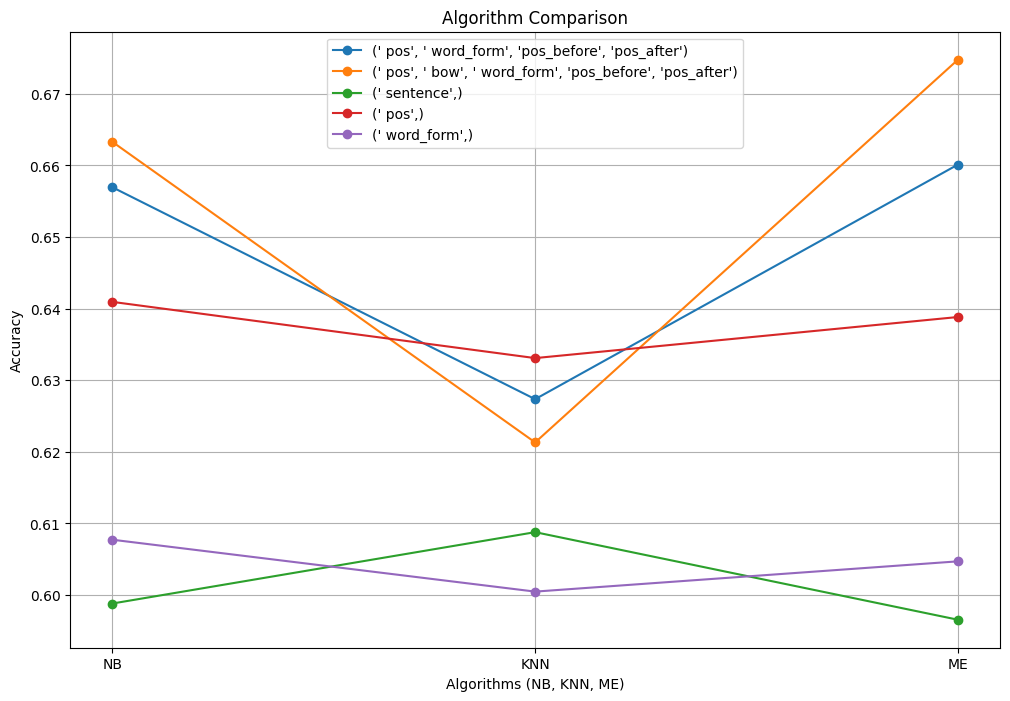

In [3]:
import matplotlib.pyplot as plt

# data = {
#     (' pos', ' bow', ' word_form', 'pos_before', 'pos_after'): {'NB': 0.6839800694549298, 'KNN': 0.6590668881171674, 'ME': 0.681111278876642},
#     (' pos', ' bow', ' word_form', 'pos_after'): {'NB': 0.6792994111429865, 'KNN': 0.6602747999396044, 'ME': 0.6847350143439529},
#     (' pos', ' bow', ' word_form', 'pos_before'): {'NB': 0.6752227087422619, 'KNN': 0.6586139211837536, 'ME': 0.6779405103427449},
#     (' sentence', ' pos', ' pos_sent', ' bow', ' word_form'): {'NB': 0.6714479842971464, 'KNN': 0.6580099652725351, 'ME': 0.675524686697871},
#     ('lemma', ' pos', ' pos_sent', ' bow'): {'NB': 0.6696361165634909, 'KNN': 0.6583119432281443, 'ME': 0.6759776536312849},
#     (' pos', ' bow', ' word_form'): {'NB': 0.6738638079420203, 'KNN': 0.6580099652725351, 'ME': 0.675524686697871},
#     ('lemma', ' pos', ' bow', ' word_form'): {'NB': 0.672353918163974, 'KNN': 0.6580099652725351, 'ME': 0.6756756756756757},
#     ('lemma', ' sentence', ' pos', ' pos_sent'): {'NB': 0.6566510644722935, 'KNN': 0.6471387588706025, 'ME': 0.6595198550505813},
#     (' sentence',): {'NB': 0.6151290955760229, 'KNN': 0.6140721727313906, 'ME': 0.6131662388645629}
# }

# Extracting data for plotting
x_values = ['NB', 'KNN', 'ME']
lines = list(data.keys())
y_values = {line: [data[line][x] for x in x_values] for line in lines}

# Plotting the data
plt.figure(figsize=(12, 8))

for line in lines:
    plt.plot(x_values, y_values[line], marker='o', label=str(line))

plt.xlabel('Algorithms (NB, KNN, ME)')
plt.ylabel('Accuracy')
plt.title('Algorithm Comparison')
plt.legend()
plt.xticks(x_values)
plt.grid(True)
plt.show()


In [66]:
print(data)

{(' pos', ' word_form', 'pos_before', 'pos_after'): {'NB': 0.6569530424279028, 'KNN': 0.6273592027781972}, (' pos', ' bow', ' word_form', 'pos_before', 'pos_after'): {'NB': 0.6632945794956968, 'KNN': 0.6213196436660123}, (' sentence',): {'NB': 0.5988222859731239, 'KNN': 0.6087875585082289}, (' pos',): {'NB': 0.640948210780613, 'KNN': 0.6330967839347728}, (' pos_sent',): {'NB': 0.5989732749509286, 'KNN': 0.6087875585082289}, (' bow',): {'NB': 0.6370224973576929, 'KNN': 0.603200966329458}}
